### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test
import pandas as pd
import random

In [2]:
def set_random_seeds(seed):
    random.seed(seed)          # Python random module
    np.random.seed(seed)       # NumPy random module
    torch.manual_seed(seed)    # PyTorch CPU random generator
    torch.cuda.manual_seed(seed)  # PyTorch GPU random generator (if using CUDA)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on CUDA
    torch.backends.cudnn.benchmark = False    # Avoid non-deterministic algorithms

In [3]:
set_random_seeds(42)
# Constants:
DATASET = 'C:\\Users\\preet\\Documents\\mBRSET\\mbrset-a-mobile-brazilian-retinal-dataset-1.0\\'
HOME_DIR = 'C:\\Users\\preet\\Documents\\mBRSET\\mBRSET\\' # change this as appropriate 
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'images')
LABEL = 'final_icdr'
TEST_SIZE = 0.3
UNDERSAMPLE = False


LABELS_PATH = os.path.join(DATASET, 'labels.csv') #labels.csv when partitioning by image
PARTITION_BY_PATIENT = True #new constant - set to true when doing train_test_split by patient rather than image
#---------------------------------

IMAGE_COL = 'file'
NORM_MEAN =  [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
BACKBONE = 'resnet50'
#BACKBONE = 'dinov2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 64 #16
NUM_WORKERS = 8 #4

LOSS = None #'focal_loss'
OPTIMIZER = 'adam'
USE_RELU = True #addition of RELU for final model classification, between the two linear layers after the backbone
# Define your hyperparameters
num_epochs = 50 
learning_rate = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [4]:
df = pd.read_csv(LABELS_PATH)
print(df.shape)

#Check for nans
nan_counts = df.isna().sum()
print(df.shape)
print(nan_counts)
# Fill missing labels as normal
df[LABEL] = df[LABEL].fillna(0)
df.head(5)

(5164, 24)
(5164, 24)
patient                           0
age                               0
sex                               0
dm_time                          56
insulin                          48
insulin_time                   4148
oraltreatment_dm                 44
systemic_hypertension            44
insurance                        48
educational_level                52
alcohol_consumption              76
smoking                          88
obesity                          76
vascular_disease                 76
acute_myocardial_infarction      84
nephropathy                      80
neuropathy                       76
diabetic_foot                   108
file                              0
laterality                        0
final_artifacts                   0
final_quality                     0
final_icdr                      280
final_edema                     265
dtype: int64


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,acute_myocardial_infarction,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no


Partitioning by patient
Train data shape: (903, 2)
Test data shape: (388, 2)


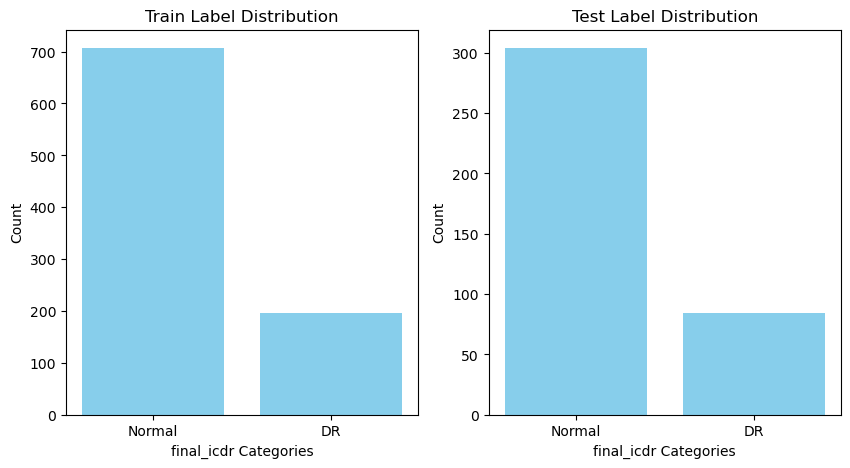

Getting validation set...
Train data shape: (310, 2)
Test data shape: (78, 2)


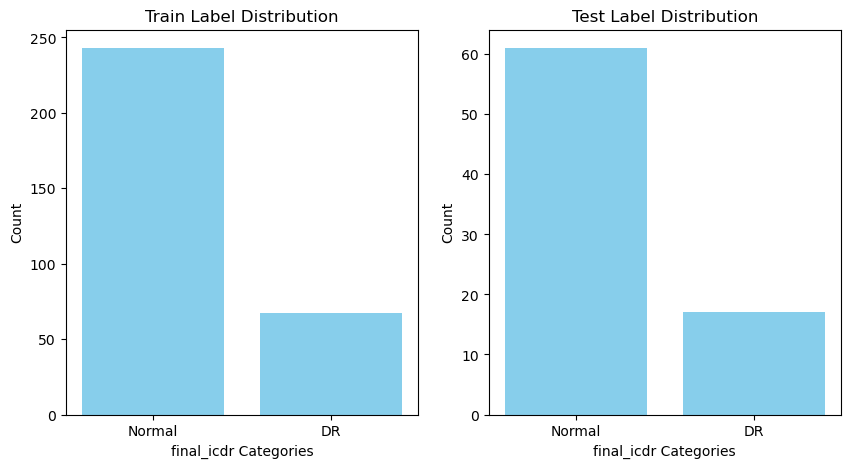

(312, 24)


In [5]:
df[LABEL] = df[LABEL].apply(lambda x: 'Normal' if x == 0.0 else ('DR'))
if PARTITION_BY_PATIENT:
    print('Partitioning by patient')
    ## LOGIC for partitioning by patient
    # Separate out patients for training and test
    k = 4
    df_subsampled = df.iloc[::k]
    df_patient = df_subsampled[['patient',LABEL]]
    df_patient.head()
    #split=0.2
    df_patient_train, df_patient_test = split_data(df_patient, LABEL, TEST_SIZE, undersample=False, random_state = 42)
    # Now find all rows in df for the patients in df_train
    train_patients = list(df_patient_train['patient'])
    
    df_train = df[df['patient'].isin(train_patients)]
    
    print('Getting validation set...')
    
    df_patient_test, df_patient_val = split_data(df_patient_test, LABEL, 0.20,random_state = 42)
    test_patients = list(df_patient_test['patient'])
    df_test = df[df['patient'].isin(test_patients)]
    
    val_patients = list(df_patient_val['patient'])
    df_val = df[df['patient'].isin(val_patients)]
    print(df_val.shape)
else:
    df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False, random_state=42)
    df_test, df_val = split_data(df_test, LABEL, 0.20,random_state = 42)


### Dataloaders

In [6]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)


0           {DR}
1           {DR}
2           {DR}
3           {DR}
4       {Normal}
          ...   
5155    {Normal}
5160    {Normal}
5161    {Normal}
5162    {Normal}
5163    {Normal}
Name: final_icdr, Length: 3612, dtype: object


In [7]:

# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

#Here we have added additional transforms: color jitter and random vertical flip to the training image embeddings
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(90),  # Randomly rotate the image by up to 10 degrees
    transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.4, contrast=0.1, saturation=0.0, hue=0.0),

])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [8]:
# Create the custom datasets
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

#Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

DF col dtype object final_icdr
DF col dtype object final_icdr
DF col dtype object final_icdr


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


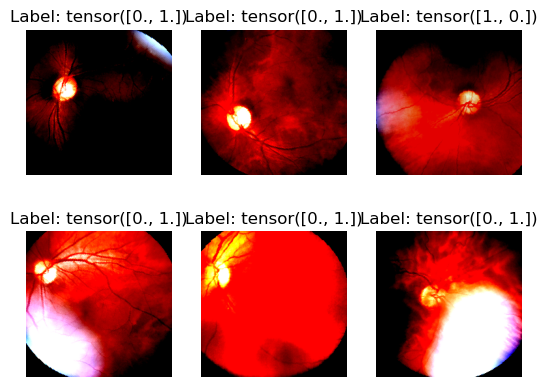

In [9]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels after transforms
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']
    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [10]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, relu= USE_RELU, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

### Training:

In [11]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)
    print(class_indices)
    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

[0 0 0 ... 1 1 1]


In [12]:
save_dir= HOME_DIR + 'Experiment3'
model = train(model, train_dataloader, val_dataloader,test_dataloader, criterion, optimizer, scheduler=None,num_epochs=num_epochs, save=True, save_dir = save_dir,device="cuda", backbone=f'convnextv2_binary_{LABEL}')

AMP True


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.02it/s]


Epoch 1
Train loss 0.672, F1 0.506, Acc 0.527, BA 0.605
cm[[ 585  201]
 [1509 1317]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.43s/it]


Epoch 1
Val loss 0.642, F1 0.529, Acc 0.545, BA 0.636
cm[[ 56  14]
 [128 114]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


cm[[226  52]
 [519 443]]
              precision    recall  f1-score   support

           0       0.30      0.81      0.44       278
           1       0.89      0.46      0.61       962

    accuracy                           0.54      1240
   macro avg       0.60      0.64      0.52      1240
weighted avg       0.76      0.54      0.57      1240

F1 0.571, Acc 0.540, BA 0.637
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:54<00:00,  1.04it/s]


Epoch 2
Train loss 0.576, F1 0.704, Acc 0.785, BA 0.719
cm[[ 473  313]
 [ 462 2364]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.56s/it]


Epoch 2
Val loss 0.602, F1 0.639, Acc 0.696, BA 0.687
cm[[ 47  23]
 [ 72 170]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


cm[[193  85]
 [282 680]]
              precision    recall  f1-score   support

           0       0.41      0.69      0.51       278
           1       0.89      0.71      0.79       962

    accuracy                           0.70      1240
   macro avg       0.65      0.70      0.65      1240
weighted avg       0.78      0.70      0.73      1240

F1 0.726, Acc 0.704, BA 0.701
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.03it/s]


Epoch 3
Train loss 0.504, F1 0.742, Acc 0.816, BA 0.755
cm[[ 510  276]
 [ 390 2436]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.39s/it]


Epoch 3
Val loss 0.558, F1 0.667, Acc 0.744, BA 0.687
cm[[ 41  29]
 [ 51 191]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.45s/it]


cm[[185  93]
 [202 760]]
              precision    recall  f1-score   support

           0       0.48      0.67      0.56       278
           1       0.89      0.79      0.84       962

    accuracy                           0.76      1240
   macro avg       0.68      0.73      0.70      1240
weighted avg       0.80      0.76      0.77      1240

F1 0.774, Acc 0.762, BA 0.728
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:54<00:00,  1.04it/s]


Epoch 4
Train loss 0.468, F1 0.762, Acc 0.829, BA 0.778
cm[[ 540  246]
 [ 371 2455]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.16s/it]


Epoch 4
Val loss 0.540, F1 0.733, Acc 0.795, BA 0.761
cm[[ 49  21]
 [ 43 199]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]


cm[[193  85]
 [186 776]]
              precision    recall  f1-score   support

           0       0.51      0.69      0.59       278
           1       0.90      0.81      0.85       962

    accuracy                           0.78      1240
   macro avg       0.71      0.75      0.72      1240
weighted avg       0.81      0.78      0.79      1240

F1 0.792, Acc 0.781, BA 0.750
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:54<00:00,  1.04it/s]


Epoch 5
Train loss 0.441, F1 0.777, Acc 0.838, BA 0.796
cm[[ 567  219]
 [ 366 2460]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.16s/it]


Epoch 5
Val loss 0.518, F1 0.742, Acc 0.801, BA 0.770
cm[[ 50  20]
 [ 42 200]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.31s/it]


cm[[197  81]
 [179 783]]
              precision    recall  f1-score   support

           0       0.52      0.71      0.60       278
           1       0.91      0.81      0.86       962

    accuracy                           0.79      1240
   macro avg       0.72      0.76      0.73      1240
weighted avg       0.82      0.79      0.80      1240

F1 0.800, Acc 0.790, BA 0.761
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.04it/s]


Epoch 6
Train loss 0.422, F1 0.792, Acc 0.851, BA 0.808
cm[[ 575  211]
 [ 326 2500]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 6
Val loss 0.513, F1 0.739, Acc 0.817, BA 0.740
cm[[ 42  28]
 [ 29 213]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]


cm[[181  97]
 [119 843]]
              precision    recall  f1-score   support

           0       0.60      0.65      0.63       278
           1       0.90      0.88      0.89       962

    accuracy                           0.83      1240
   macro avg       0.75      0.76      0.76      1240
weighted avg       0.83      0.83      0.83      1240

F1 0.828, Acc 0.826, BA 0.764


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.03it/s]


Epoch 7
Train loss 0.386, F1 0.809, Acc 0.863, BA 0.828
cm[[ 603  183]
 [ 313 2513]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.37s/it]


Epoch 7
Val loss 0.499, F1 0.750, Acc 0.808, BA 0.780
cm[[ 51  19]
 [ 41 201]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


cm[[205  73]
 [178 784]]
              precision    recall  f1-score   support

           0       0.54      0.74      0.62       278
           1       0.91      0.81      0.86       962

    accuracy                           0.80      1240
   macro avg       0.73      0.78      0.74      1240
weighted avg       0.83      0.80      0.81      1240

F1 0.808, Acc 0.798, BA 0.776
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:53<00:00,  1.06it/s]


Epoch 8
Train loss 0.390, F1 0.804, Acc 0.857, BA 0.827
cm[[ 607  179]
 [ 337 2489]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.68s/it]


Epoch 8
Val loss 0.509, F1 0.742, Acc 0.811, BA 0.756
cm[[ 46  24]
 [ 35 207]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:30<00:00,  1.53s/it]


cm[[194  84]
 [133 829]]
              precision    recall  f1-score   support

           0       0.59      0.70      0.64       278
           1       0.91      0.86      0.88       962

    accuracy                           0.82      1240
   macro avg       0.75      0.78      0.76      1240
weighted avg       0.84      0.82      0.83      1240

F1 0.830, Acc 0.825, BA 0.780


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:59<00:00,  1.05s/it]


Epoch 9
Train loss 0.378, F1 0.811, Acc 0.864, BA 0.831
cm[[ 609  177]
 [ 316 2510]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.20s/it]


Epoch 9
Val loss 0.517, F1 0.755, Acc 0.830, BA 0.753
cm[[ 43  27]
 [ 26 216]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.25s/it]


cm[[189  89]
 [125 837]]
              precision    recall  f1-score   support

           0       0.60      0.68      0.64       278
           1       0.90      0.87      0.89       962

    accuracy                           0.83      1240
   macro avg       0.75      0.77      0.76      1240
weighted avg       0.84      0.83      0.83      1240

F1 0.831, Acc 0.827, BA 0.775
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:52<00:00,  1.08it/s]


Epoch 10
Train loss 0.362, F1 0.815, Acc 0.865, BA 0.840
cm[[ 625  161]
 [ 328 2498]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.12s/it]


Epoch 10
Val loss 0.513, F1 0.733, Acc 0.801, BA 0.750
cm[[ 46  24]
 [ 38 204]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


cm[[203  75]
 [152 810]]
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       278
           1       0.92      0.84      0.88       962

    accuracy                           0.82      1240
   macro avg       0.74      0.79      0.76      1240
weighted avg       0.84      0.82      0.82      1240

F1 0.824, Acc 0.817, BA 0.786


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:53<00:00,  1.07it/s]


Epoch 11
Train loss 0.353, F1 0.814, Acc 0.863, BA 0.840
cm[[ 627  159]
 [ 335 2491]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.09s/it]


Epoch 11
Val loss 0.545, F1 0.763, Acc 0.843, BA 0.752
cm[[ 41  29]
 [ 20 222]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.25s/it]


cm[[181  97]
 [ 80 882]]
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       278
           1       0.90      0.92      0.91       962

    accuracy                           0.86      1240
   macro avg       0.80      0.78      0.79      1240
weighted avg       0.85      0.86      0.86      1240

F1 0.856, Acc 0.857, BA 0.784
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:51<00:00,  1.10it/s]


Epoch 12
Train loss 0.355, F1 0.819, Acc 0.870, BA 0.837
cm[[ 613  173]
 [ 297 2529]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.21s/it]


Epoch 12
Val loss 0.534, F1 0.741, Acc 0.814, BA 0.748
cm[[ 44  26]
 [ 32 210]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


cm[[198  80]
 [126 836]]
              precision    recall  f1-score   support

           0       0.61      0.71      0.66       278
           1       0.91      0.87      0.89       962

    accuracy                           0.83      1240
   macro avg       0.76      0.79      0.77      1240
weighted avg       0.85      0.83      0.84      1240

F1 0.838, Acc 0.834, BA 0.791


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:54<00:00,  1.04it/s]


Epoch 13
Train loss 0.341, F1 0.828, Acc 0.874, BA 0.855
cm[[ 645  141]
 [ 315 2511]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.45s/it]


Epoch 13
Val loss 0.534, F1 0.748, Acc 0.824, BA 0.749
cm[[ 43  27]
 [ 28 214]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


cm[[197  81]
 [111 851]]
              precision    recall  f1-score   support

           0       0.64      0.71      0.67       278
           1       0.91      0.88      0.90       962

    accuracy                           0.85      1240
   macro avg       0.78      0.80      0.79      1240
weighted avg       0.85      0.85      0.85      1240

F1 0.848, Acc 0.845, BA 0.797


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:52<00:00,  1.08it/s]


Epoch 14
Train loss 0.315, F1 0.844, Acc 0.889, BA 0.861
cm[[ 639  147]
 [ 255 2571]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.05s/it]


Epoch 14
Val loss 0.577, F1 0.759, Acc 0.849, BA 0.735
cm[[ 37  33]
 [ 14 228]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.34s/it]


cm[[171 107]
 [ 65 897]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       278
           1       0.89      0.93      0.91       962

    accuracy                           0.86      1240
   macro avg       0.81      0.77      0.79      1240
weighted avg       0.86      0.86      0.86      1240

F1 0.857, Acc 0.861, BA 0.774


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.04it/s]


Epoch 15
Train loss 0.307, F1 0.840, Acc 0.883, BA 0.869
cm[[ 665  121]
 [ 303 2523]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.18s/it]


Epoch 15
Val loss 0.553, F1 0.775, Acc 0.849, BA 0.766
cm[[ 43  27]
 [ 20 222]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]


cm[[191  87]
 [101 861]]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       278
           1       0.91      0.90      0.90       962

    accuracy                           0.85      1240
   macro avg       0.78      0.79      0.79      1240
weighted avg       0.85      0.85      0.85      1240

F1 0.850, Acc 0.848, BA 0.791
Saving


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:53<00:00,  1.07it/s]


Epoch 16
Train loss 0.320, F1 0.840, Acc 0.884, BA 0.863
cm[[ 649  137]
 [ 281 2545]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.14s/it]


Epoch 16
Val loss 0.567, F1 0.761, Acc 0.846, BA 0.743
cm[[ 39  31]
 [ 17 225]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]


cm[[177 101]
 [ 69 893]]
              precision    recall  f1-score   support

           0       0.72      0.64      0.68       278
           1       0.90      0.93      0.91       962

    accuracy                           0.86      1240
   macro avg       0.81      0.78      0.79      1240
weighted avg       0.86      0.86      0.86      1240

F1 0.860, Acc 0.863, BA 0.782


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.02it/s]


Epoch 17
Train loss 0.307, F1 0.852, Acc 0.892, BA 0.878
cm[[ 671  115]
 [ 276 2550]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.35s/it]


Epoch 17
Val loss 0.568, F1 0.756, Acc 0.833, BA 0.750
cm[[ 42  28]
 [ 24 218]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]


cm[[188  90]
 [ 92 870]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.67       278
           1       0.91      0.90      0.91       962

    accuracy                           0.85      1240
   macro avg       0.79      0.79      0.79      1240
weighted avg       0.85      0.85      0.85      1240

F1 0.853, Acc 0.853, BA 0.790


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:54<00:00,  1.05it/s]


Epoch 18
Train loss 0.305, F1 0.845, Acc 0.887, BA 0.868
cm[[ 656  130]
 [ 277 2549]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.54s/it]


Epoch 18
Val loss 0.579, F1 0.741, Acc 0.830, BA 0.728
cm[[ 38  32]
 [ 21 221]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


cm[[184  94]
 [102 860]]
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       278
           1       0.90      0.89      0.90       962

    accuracy                           0.84      1240
   macro avg       0.77      0.78      0.78      1240
weighted avg       0.84      0.84      0.84      1240

F1 0.843, Acc 0.842, BA 0.778


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.03it/s]


Epoch 19
Train loss 0.292, F1 0.851, Acc 0.892, BA 0.874
cm[[ 662  124]
 [ 265 2561]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.14s/it]


Epoch 19
Val loss 0.568, F1 0.737, Acc 0.821, BA 0.732
cm[[ 40  30]
 [ 26 216]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]


cm[[197  81]
 [117 845]]
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       278
           1       0.91      0.88      0.90       962

    accuracy                           0.84      1240
   macro avg       0.77      0.79      0.78      1240
weighted avg       0.85      0.84      0.84      1240

F1 0.844, Acc 0.840, BA 0.794


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:55<00:00,  1.02it/s]


Epoch 20
Train loss 0.297, F1 0.843, Acc 0.885, BA 0.870
cm[[ 664  122]
 [ 294 2532]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.48s/it]


Epoch 20
Val loss 0.581, F1 0.744, Acc 0.830, BA 0.733
cm[[ 39  31]
 [ 22 220]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.29s/it]


cm[[193  85]
 [100 862]]
              precision    recall  f1-score   support

           0       0.66      0.69      0.68       278
           1       0.91      0.90      0.90       962

    accuracy                           0.85      1240
   macro avg       0.78      0.80      0.79      1240
weighted avg       0.85      0.85      0.85      1240

F1 0.852, Acc 0.851, BA 0.795


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:58<00:00,  1.03s/it]


Epoch 21
Train loss 0.267, F1 0.856, Acc 0.895, BA 0.883
cm[[ 678  108]
 [ 271 2555]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.56s/it]


Epoch 21
Val loss 0.625, F1 0.731, Acc 0.827, BA 0.716
cm[[ 36  34]
 [ 20 222]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.42s/it]


cm[[182  96]
 [ 80 882]]
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       278
           1       0.90      0.92      0.91       962

    accuracy                           0.86      1240
   macro avg       0.80      0.79      0.79      1240
weighted avg       0.86      0.86      0.86      1240

F1 0.857, Acc 0.858, BA 0.786


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:57<00:00,  1.02s/it]


Epoch 22
Train loss 0.263, F1 0.871, Acc 0.908, BA 0.891
cm[[ 676  110]
 [ 222 2604]]


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.13s/it]


Epoch 22
Val loss 0.552, F1 0.764, Acc 0.837, BA 0.763
cm[[ 44  26]
 [ 25 217]]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.27s/it]

cm[[198  80]
 [120 842]]
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       278
           1       0.91      0.88      0.89       962

    accuracy                           0.84      1240
   macro avg       0.77      0.79      0.78      1240
weighted avg       0.85      0.84      0.84      1240

F1 0.842, Acc 0.839, BA 0.794
Early stopping triggered.


### 

Test

In [13]:
state_dict = torch.load(HOME_DIR + 'Experiment3\\fine_tuned_resnet50_best.pth')
model.load_state_dict(state_dict, strict=True) 
y_pred, y_true = test(model, test_dataloader, saliency=False, device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]

cm[[191  87]
 [101 861]]
              precision    recall  f1-score   support

           0       0.65      0.69      0.67       278
           1       0.91      0.90      0.90       962

    accuracy                           0.85      1240
   macro avg       0.78      0.79      0.79      1240
weighted avg       0.85      0.85      0.85      1240

F1 0.850, Acc 0.848, BA 0.791


In [14]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score,balanced_accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

def atleastOne(lst):
    for i in range(0, 4):
        if(lst[i] > 0.5):
            return True
    return False


final_ypred_lst = []
for i in range(len(y_pred)//4): 
    a = y_pred[4*i:4*i + 4] 
    b = atleastOne(a)
    final_ypred_lst.append(b) 

print(y_true)
final_ytrue_lst = []
for i in range(len(y_true)//4):
    a = y_true[4*i:4*i + 4] 
    b = atleastOne(a)
    final_ytrue_lst.append(b) 

print(len(final_ytrue_lst))

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
import csv 
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score,balanced_accuracy_score
cm = confusion_matrix(final_ytrue_lst, final_ypred_lst)
print(cm)

f1 = f1_score(final_ytrue_lst, final_ypred_lst, average='macro')
acc = accuracy_score(final_ytrue_lst, final_ypred_lst)
ba = balanced_accuracy_score(final_ytrue_lst, final_ypred_lst)
print("F1 {c:.3f}, Acc {d:.3f}, BA {e:.3f}".format(c=f1, d = acc, e= ba))

df_test[['patient',LABEL]].head(16)
#Load labels_modified_clean and check
#df_test.to_csv("temp.csv")
cr = classification_report(final_ytrue_lst, final_ypred_lst)
    # print classification report
print(cr)